In [3]:
import pandas as pd
import numpy as np
from scipy import sparse
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics
import src.rainbow
import os
import glob
import pickle

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Import the jsonified transactions into a dataframe

In [5]:
path = '/Users/Sarah/galvanize/dsi-capstone/jsons/account/'
all_files = glob.glob(os.path.join(path, "*.json"))

In [6]:
df = pd.concat((pd.read_json(f,keep_default_dates=False,lines=True) for f in all_files)) 

In [7]:
for types in df.type.unique():
    print(types)    

Checkout


In [8]:
df=df[df['type']=='Checkout']

In [9]:
for term in df.term.unique():
    print(term)
    

11
6
5
10
8
1
3
4
2
7
9


Drop transactions from register other than 1-9. Register 10 is the customer service desk returns register. Register 11 is the worker self checkout register.

In [10]:
df=df[df['term']<10]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63802 entries, 14 to 2811
Data columns (total 11 columns):
account    63802 non-null object
date       63802 non-null object
gross+     63802 non-null float64
gross-     63802 non-null float64
items      63802 non-null object
net        63802 non-null float64
oper       63802 non-null int64
term       63802 non-null int64
time       63802 non-null object
trans      63802 non-null int64
type       63802 non-null object
dtypes: float64(3), int64(3), object(5)
memory usage: 5.8+ MB


In [12]:
df['date']=pd.to_datetime(df['date'],yearfirst=True)

In [13]:
df['day_of_week']=df['date'].dt.day_name()
df['month']=df['date'].dt.month

In [14]:
pickle.dump(df,open('./pickles/df2018account.p','wb'))

In [11]:
df = pickle.load(open('./pickles/df2018account.p','rb'))

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63802 entries, 14 to 2811
Data columns (total 13 columns):
account        63802 non-null object
date           63802 non-null datetime64[ns]
gross+         63802 non-null float64
gross-         63802 non-null float64
items          63802 non-null object
net            63802 non-null float64
oper           63802 non-null int64
term           63802 non-null int64
time           63802 non-null object
trans          63802 non-null int64
type           63802 non-null object
day_of_week    63802 non-null object
month          63802 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(4), object(5)
memory usage: 6.8+ MB


In [16]:
#quarter1 = df[(df['month']>=1) & (df['month']<=3)]

## Import just one day into a dataframe 

In [17]:
#df=pd.read_json('./jsons/1.json',keep_default_dates=False,lines=True)

In [24]:
df['account'].unique()

TypeError: unhashable type: 'list'

In [19]:
def get_items(df,most_common=10,least_common=5):
    df['total_of_items'] = 0
    stoppers = ['BAG CREDIT','SF Bag Charge','Gift Card Reload','8 OZ BIO TUB t3', '16OZ BIO TUB t4',
                 '32OZ BIO TUB t5','BOTTLE DEPOSIT','6PACK BEER SMALL C','PAID IN','Gift Card Sale','PACKAGED FOOD', ]  
    '''build a dictionary where the keys are the words
    in the dataframe items column'''
    
    items=[]
    item_dict = defaultdict(int)
    basket_counts=[]
    
    for basket in df['items']:
        basket_counts.append(len(basket))
        for item in basket:
            items.append(item[1])
            item_dict[item[1]] += 1
    
    items_set=set(items)

    
    '''add the most common words to the stopwords list'''
    stopwords=list([i[0] for i in Counter(item_dict).most_common(most_common)])
    
    for s in stoppers:
        stopwords.append(s)
        
    '''add items containing "CRV" to the stopwords list'''
    for item in items_set:
        if "crv" in item.lower():
            stopwords.append(item)
    
    '''add the least common words to the stopwords list'''
    for key,value in item_dict.items():
        if value < least_common:
            stopwords.append(key)
    print(type(stopwords) )  
    stopwords = set(stopwords)
    
    '''iterate through the baskets and add items to items_set
    if not in stopwords (too common or too uncommon)'''
    for stops in stopwords:
        items_set.remove(stops)
  

    return items_set,stopwords, item_dict, basket_counts

items_set,stopwords,item_dict, basket_counts = get_items(df,most_common=5,least_common=5)

<class 'list'>


In [17]:
Counter(item_dict).most_common(25)

[('BAG CREDIT', 686340),
 ('SF Bag Charge', 202311),
 ('SMALL COOLER CRV', 169185),
 ('BANANAS', 115225),
 ('AVOCADOS HASS', 85530),
 ('ONIONS YELLOW', 66866),
 ('8 OZ BIO TUB t3', 60526),
 ('CRV LRG SING NOTAX', 57613),
 ('APPLES FUJI', 54467),
 ('CRV SMALL SING T', 53742),
 ('CRV SMALL NO TAX', 52913),
 ('GARLIC WHITE', 48455),
 ('LARGE COOLER CRV', 42705),
 ('LEMONS', 42355),
 ('16OZ BIO TUB t4', 40108),
 ('PEPPERS RED BELL', 38047),
 ('CELERY', 37538),
 ('CRV LRG SING T', 36623),
 ('BOTTLE DEPOSIT', 36356),
 ('KALE DINO', 35408),
 ('CARROTS LOOSE', 35196),
 ('SQUASH ZUCCHINI', 34051),
 ('GINGER', 33767),
 ('ONIONS RED', 33293),
 ('CILANTRO', 32712)]

In [18]:
df['item_count']=basket_counts

In [19]:
percentile = np.percentile(basket_counts, [25, 50, 75])
q1=percentile[0]
q2=percentile[1]
q3=percentile[2]

In [20]:
q1,q2,q3

(4.0, 9.0, 17.0)

In [783]:
dfq1=df[(df['item_count']<=q1)]
dfq2=df[(df['item_count']>q1 )& (df['item_count']<=q2)]
dfq3=df[(df['item_count']>q2 )& (df['item_count']<=q3)]
dfq4=df[df['item_count']>q3]
df_avg=df[(df['item_count']>=10 )& (df['item_count']<=12)]

In [785]:
#df = df_avg

In [21]:
df['item_count'].max()

251

In [22]:
item_matrix = np.zeros((df.shape[0],len(items_set)))

In [23]:
df_items= pd.DataFrame(item_matrix,columns=items_set)

In [24]:
df.index

Int64Index([   5,    9,   10,   12,   13,   14,   15,   16,   17,   18,
            ...
            2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824],
           dtype='int64', length=831284)

In [25]:
df=df.reset_index()

In [26]:
df.index

RangeIndex(start=0, stop=831284, step=1)

In [27]:
df.describe()

,index,gross+,gross-,net,oper,term,trans,month,total_of_items,item_count
count,831284.000000,831284.000000,831284.000000,831284.000000,831284.000000,831284.000000,831284.000000,831284.000000,831284.0,831284.000000
mean,1270.845914,65.388330,2.079210,63.309240,52.691926,4.376811,158.393187,6.529922,0.0,12.612510
std,736.755845,197.046072,182.565605,72.540467,27.672120,2.548131,108.165460,3.447604,0.0,12.339016
min,0.000000,0.000000,0.000000,-481.450000,1.000000,1.000000,1.000000,1.000000,0.0,0.000000
25%,635.000000,17.490000,0.000000,17.210000,26.000000,2.000000,71.000000,4.000000,0.0,4.000000
50%,1262.000000,41.700000,0.000000,41.050000,55.000000,4.000000,144.000000,7.000000,0.0,9.000000
75%,1890.000000,85.070000,0.000000,83.670000,78.000000,6.000000,228.000000,10.000000,0.0,17.000000
max,3335.000000,89473.800000,89374.990000,8195.040000,110.000000,9.000000,678.000000,12.000000,0.0,251.000000


In [28]:
df.pop('index')
print ()

In [29]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831284 entries, 0 to 831283
Data columns (total 14 columns):
date              831284 non-null datetime64[ns]
gross+            831284 non-null float64
gross-            831284 non-null float64
items             831284 non-null object
net               831284 non-null float64
oper              831284 non-null int64
term              831284 non-null int64
time              831284 non-null object
trans             831284 non-null int64
type              831284 non-null object
day_of_week       831284 non-null object
month             831284 non-null int64
total_of_items    831284 non-null int64
item_count        831284 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(6), object(4)
memory usage: 88.8+ MB


In [30]:
df.iloc[:,0].index


RangeIndex(start=0, stop=831284, step=1)

In [31]:
df_items.iloc[:,0].index

RangeIndex(start=0, stop=831284, step=1)

In [32]:
col_index_dict = dict(zip(items_set, range(len(items_set))))

In [33]:
#col_index_dict

In [33]:
matrix = np.zeros(df_items.shape)
matrix.shape

(63802, 13028)

In [80]:
df.shape[0]

63802

In [34]:
    matrix_dict = defaultdict(int)
    for i in range(df.shape[0]):
        for item in df['items'][i]:
            #set matrix to boolean for item precence in basket:
            if item[1] not in stopwords:
                if item[2] > 0:
                    value = 1
                elif item[2] == 0:
                    value = 0
                else:
                    value = -1
                matrix_dict[i,col_index_dict[item[1]]] += value #+ matrix_dict[(i,item[1])]
                #matrix[i,col_index_dict[ item[1] ]] = matrix[i,col_index_dict[ item[1] ]] + value
            '''if item[1] not in stopwords and item[2] > 0:
                matrix[i,col_index_dict[ item[1] ]] = 1
            if item[1] not in stopwords and item[2] < 0:
                matrix[i,col_index_dict[ item[1] ]] = 0'''
    #matrix = (matrix > 0).astype(int)
 

In [35]:
len(matrix_dict)

7585846

In [36]:
for key,value in matrix_dict.items():
    print (key[0])
    print (key[1])
    print (value)
    break

1
5981
1


In [37]:
rows, cols, vals = [], [], []
for key, value in matrix_dict.items():
    rows.append(key[0])
    cols.append(key[1])
    vals.append(matrix_dict[key])
sparse_matrix = sparse.csr_matrix((vals, (rows, cols)))

In [31]:
len(rows)

555217

In [32]:
import pickle

In [38]:
sparse_matrix[4]

<1x31479 sparse matrix of type '<class 'numpy.int64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [39]:
pickle.dump(sparse_matrix,open('./pickles.sparse_matrix2018.p','wb'))

In [39]:
pickle.dump(items_set,open('./pickles.sparse_matrix2018.p','wb'))

In [43]:
file = open("./sparse_matrix201802orig.p",'rb')
sparse_matrix_orig = pickle.load(file)
file.close()

In [ ]:
for s in sparse_matrix[1:,9]:
    print (s)

In [63]:
for s in sparse_matrix_orig[0]:
    print (s)

  (0, 852)	1


In [48]:
diff = sparse_matrix-sparse_matrix_orig

In [49]:
diff.sum()

51149

In [51]:
file = open("./pickles/items_set.p",'rb')
items_set_old = pickle.load(file)
file.close()

In [55]:
#items_set_old

In [56]:
for l in range(len(items_set_old)):
    print (items_set[l])
    print(items_set_old[l])

TypeError: 'set' object does not support indexing

In [40]:
file = open("./sparse_matrix201802.p",'rb')
sparse_matrix = pickle.load(file)
file.close()

In [41]:
file = open("./items_set201802.p",'rb')
items_set = pickle.load(file)
file.close()

In [46]:
sparse_matrix = (sparse_matrix > 0).astype(int)

In [66]:
#count rows of baskets with a total of 0 weight items
sum_of_zeros=0
for i in range(sparse_matrix.shape[0]):
    if sparse_matrix[i].sum()<1:
        sum_of_zeros+=1
print (sum_of_zeros)

3092


In [102]:
print(sum_of_zeros / sparse_matrix.shape[0],"% of zero weight baskets")

0.0004968217841315362 % of zero weight baskets


In [ ]:
#Set all negative values in the matrix to 0.
#matrix = pickle.load('matrix.p','rb')
#matrix = (matrix > 0).astype(int)

In [103]:
matrix.shape[0]

NameError: name 'matrix' is not defined

In [47]:
sparse_matrix[1111].sum()

6

In [75]:
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics

In [76]:
def nmf_funct(sparse_matrix,n_components=10):
    from sklearn.decomposition import NMF
    model = NMF(n_components=n_components,max_iter=500)
    W = model.fit_transform(sparse_matrix)
    H=model.components_
    model_iter = model.n_iter_
    return model,W,H,model_iter

In [78]:
scores =[]
for i in range(1,25,5):
    iter=i
    iteration,score,model_iter = scoring(iter,sparse_matrix,matrix)
    print(iteration,score)
    scores.append([iteration,score,model_iter])

NameError: name 'scoring' is not defined

In [406]:
just_scores=[]
for s in range(len(scores)):
    just_scores.append(scores[s][1])


In [79]:
#scores

In [80]:
#just_scores

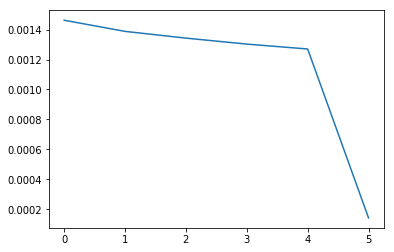

In [409]:
plt.plot(np.arange(len(just_scores[24:30])),(just_scores[24:30]))


In [722]:
scores[24:30]

[[1, 0.001462029804203652, 5],
 [6, 0.0013877529690621115, 95],
 [11, 0.0013427198413541964, 96],
 [16, 0.0013029291315034713, 292],
 [21, 0.0012701763318097284, 243],
 [1, 0.0001431933907664586, 6]]

In [411]:
for i in range(10,101,10):
    iter=i
    print (iter)

10
20
30
40
50
60
70
80
90
100


In [ ]:
rebuilt = np.dot(W,H)

In [ ]:
rebuilt.shape

In [ ]:
matrix.shape

In [108]:
rebuilt-matrix

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.29976971e-04, 3.29969297e-04, 2.11526977e-04, ...,
        1.46095233e-04, 9.08517333e-04, 6.24379430e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.05683634e-05, 7.16348659e-05, 8.00710503e-05, ...,
        4.00441875e-05, 2.78065699e-04, 2.19722093e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [121]:
np.mean((rebuilt-matrix)**2)

0.09009532798915376

n_components:
1   =  .0001
2   = 0.0013937693036813904
3   = 0.001383618220432841
10  = 0.0013233378763788833
100 =-0.0003337663571822616
100 = 0.001324181632724416

In [129]:
scorer=metrics.explained_variance_score
prediction = model.inverse_transform(model.transform(sparse_matrix))
scorer(matrix, prediction)

0.018682112359056913

In [130]:
prediction


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.29976672e-04, 3.29950574e-04, 2.11518553e-04, ...,
        1.46131375e-04, 9.08533609e-04, 6.24109411e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.05695823e-05, 7.16348761e-05, 8.00711799e-05, ...,
        4.00437082e-05, 2.78061313e-04, 2.19714633e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [57]:
def fit_NMF(sparse_matrix_,n_components_,max_iter=250):
    from sklearn.decomposition import NMF
    model = NMF(n_components=n_components_,max_iter=max_iter)
    W = model.fit_transform(sparse_matrix_)
    H=model.components_
    model_iter = model.n_iter_
    return model,W,H,model_iter
model,W,H,model_iter = fit_NMF(sparse_matrix,n_components_=10,max_iter=250)

In [58]:
model_iter

224

In [59]:
H.shape

(10, 31479)

In [60]:
W.shape

(831284, 10)

In [95]:
w=W.copy()
w_boolean = w[1]==w[1].max()

In [113]:
w = np.zeros_like(W)
w[np.arange(len(W)), W.argmax(1)] = 1
np.sum(w,axis=0)

array([511729.,  39899.,  22739.,  33324.,  37451.,  31927.,  70397.,
        21362.,  38164.,  24292.])

In [114]:
print(np.sum(w_boolean,axis=1))

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
model = LDA(n_components=2,max_iter=10)
W = model.fit_transform(sparse_matrix)
H = model.components_
model.n_iter_

In [107]:
H[:,6249]

array([0.00568646, 0.        , 0.00035769, 0.00134455, 0.        ,
       0.        , 0.00069092, 0.00292025, 0.00037241, 0.        ])

In [115]:
len(items_set)

13028

In [113]:
for topic in H:
    print (topic[:-10:-1])

[0.         0.00441505 0.00980141 0.012876   0.00077077 0.00070029
 0.00279214 0.00139771 0.00023004]
[0.         0.0003581  0.00854664 0.00034471 0.         0.
 0.00219412 0.0002887  0.        ]
[0.00303419 0.         0.         0.         0.         0.
 0.         0.         0.        ]
[1.10003786e-03 7.70094654e-05 0.00000000e+00 7.28138922e-04
 2.05204203e-04 0.00000000e+00 5.68327946e-04 0.00000000e+00
 0.00000000e+00]
[0.00634289 0.         0.00058664 0.00592629 0.         0.
 0.         0.         0.00058325]
[0.         0.         0.         0.01045207 0.00373818 0.
 0.         0.00050529 0.00150277]
[0.         0.         0.00644136 0.00168612 0.00385706 0.
 0.         0.         0.        ]
[0.00431008 0.         0.         0.00289049 0.         0.00380935
 0.0015475  0.00651437 0.00030573]
[0.00108092 0.00126485 0.00048298 0.00138168 0.         0.00388154
 0.         0.0004808  0.00189265]
[0.00409015 0.00117578 0.00151741 0.         0.         0.
 0.00086623 0.         0. 

In [70]:
file = open("./pickles/items_set.p",'rb')
items_set = pickle.load(file)
file.close()

In [115]:
feature_names=list(items_set).copy()
n_top_words=50
for topic in H:
    print(topic.argsort()[:-n_top_words -1:-1])
    print ([feature_names[i]for i in topic.argsort()[:-n_top_words -1:-1]])
    print()

[ 6792  3228 26517 25768  3544  2739 29824  9165 14890  7268 17233 25296
 25808 31155 22789 16422 13170  4941 19873 31125 28991 25933 18518 10768
 18495 11378  3278 13184 30149 15955  8477 28612 19978 14843  4540 15038
 25306 20649 26512 16035 21738 16564 14035 25864 19897 12397   171 19650
 12332 11021]
['KALE DINO', '1lb STRAWBERRY', 'CARROTS BUNCH', 'TOMATO DRY FARM', 'BROCCOLI LOOSE', 'SPINACH LOOSE', 'ARUGULA LOOSE', 'NECTARINE', 'PEACH', 'LETTUCE SALAD MIX', '5290 WALNUTS', 'BEANS GREEN', 'BAGEL', 'TOMATO MIX HEIRLOO', 'CUKE MEDIT/PERSIAN', 'CORN', 'CUCUMBERS', 'POTATOES GARNET', 'PLUOT/PLUM RED', 'MUSHROOM CRIMINI', '5120 ORG ALMONDS', 'REFRIGERATED', 'GRAPES RED', 'APPLES GALA', 'BROCCOLI BABY SWEE', 'CAULIFLOWER BULK', 'ORANGES VALENCIA', 'MUSHROOMS SHIITAKE', 'GRAPEFRUIT', 'POTATOES YELLOW', 'HERBS BASIL', 'ASPARAGUS', '3185 ORG MANGO', 'PEAR BARTLETT', '2448 CASTEL OLIVE', 'RADISHES RED/FRENC', 'APPLES PINK LADY', 'LETTUCE RED BUTTER', 'BLUEBERRY', 'BLUBERRIES PINT', 'BEETS 

Topic #0:
['KALE DINO', '1lb STRAWBERRY', 'CARROTS BUNCH', 'TOMATO DRY FARM', 'BROCCOLI LOOSE', 'SPINACH LOOSE', 'ARUGULA LOOSE', 'NECTARINE', 'PEACH', 'LETTUCE SALAD MIX', '5290 WALNUTS', 'BEANS GREEN', 'BAGEL', 'TOMATO MIX HEIRLOO', 'CUKE MEDIT/PERSIAN', 'CORN', 'CUCUMBERS', 'POTATOES GARNET', 'PLUOT/PLUM RED', 'MUSHROOM CRIMINI', '5120 ORG ALMONDS', 'REFRIGERATED', 'GRAPES RED', 'APPLES GALA', 'BROCCOLI BABY SWEE', 'CAULIFLOWER BULK', 'ORANGES VALENCIA', 'MUSHROOMS SHIITAKE', 'GRAPEFRUIT', 'POTATOES YELLOW', 'HERBS BASIL', 'ASPARAGUS', '3185 ORG MANGO', 'PEAR BARTLETT', '2448 CASTEL OLIVE', 'RADISHES RED/FRENC', 'APPLES PINK LADY', 'LETTUCE RED BUTTER', 'BLUEBERRY', 'BLUBERRIES PINT', 'BEETS RED LOOSE', 'POTATOES JAPANESE', 'CABBAGE RED', 'SUGAR PLUM CLAM', 'MANGO', 'MINI SEEDLESS H20', 'ORANGES NAVEL', 'LETTUCE RED LEAF', 'LEMONS MEYER', 'KALE GREEN']


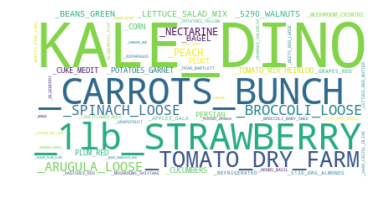

<img src="./img/2018/year.topic0.png">
Topic #1:
['APPLES FUJI', 'ORANGES NAVEL', 'SATSUMA MANDARIN', 'PEAR BARTLETT', 'PEAR BOSC', 'PERSIMMONS FUYU', 'ORANGES VALENCIA', 'GRAPEFRUIT', 'PEARS RED', 'KIWI LOOSE', 'BLUEBERRY', 'POTATOES JAPANESE', '3185 ORG MANGO', 'GRAPES RED', 'REFRIGERATED', 'CARA CARA NAVEL', 'POTATOES GARNET', 'MANGO', 'CARROTS BABY', 'WHOLE ORG MILK', 'TANGELO MINNEOLA', 'MANDERINE GOLD NU', 'POMEGRANATES', 'BLUEBERRY PACKAGE', 'TOMATOES ROMA', 'LEMONS MEYER', '5120 ORG ALMONDS', 'LETTUCE RED LEAF', 'LETTUCE RED BUTTER', '4110 ROLLED OATS', 'STRAUS PLN YOG QT', 'MANDARINES MURCOTT', '2448 CASTEL OLIVE', '5290 WALNUTS', 'ORANGES BLOOD', 'BEETS RED LOOSE', 'BLACKBERRY PACK', 'SUGAR PLUM CLAM', 'super greens', 'BAGEL', 'KALE GREEN', 'STRAUS MILK 64oz', 'ORG WM QT CLOVER', 'SQUASH BUTTERNUT', '3290 THOMPSON RAIS', 'BEANS GREEN', '5132 R/NS ALMONDS', '4125 OG STL CUT OA', 'ORGANIC 2% MILK', 'POTATOES RUSSET']


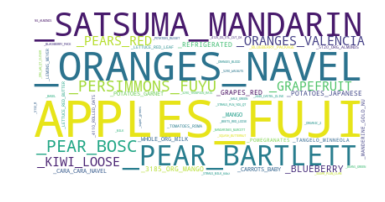

<img src="./img/2018/year.topic1.png">
Topic #2:
['ONIONS YELLOW', 'POTATOES YELLOW', 'POTATOES RUSSET', 'POTATOES GARNET', 'MUSHROOM CRIMINI', 'LEEKS', 'CARROTS BUNCH', 'PEPPERS GREEN BELL', 'TOMATOES ROMA', 'SQUASH BUTTERNUT', 'CABBAGE GREEN', 'PARSLEY ITALIAN', 'POTATOES JAPANESE', 'ORANGES NAVEL', 'POTATOES RED', 'SHALLOTS', 'BRUSSEL SPROUTS', 'MUSHROOMS SHIITAKE', 'CAULIFLOWER BULK', 'PARMIGIANO REGG', 'EGGPLANT GLOBE', 'ROOTS PARSNIP', 'SATSUMA MANDARIN', 'FENNEL', 'POTATOES JEWEL', '4110 ROLLED OATS', 'CAULIFLOWER CELLO', 'WHOLE ORG MILK', 'APPLES PINK LADY', 'STRAUS PLN YOG QT', 'BEANS GREEN', 'ORG Whipping crm', 'EGGS DZ ST JOHN', '3680 BAKERS CH FLO', 'PERSIMMONS FUYU', '2215 ORGANIC LENTI', 'GREEN ONIONS', 'CLO UNSALTED BUTTE', 'ORG 1LB BUTTER', 'BROCCOLI BABY SWEE', 'EGGS DZ ROCK LG', 'TOMATOES CLUSTER', '8161 ORG CUMIN PWD', '8036 BAY LEAF ORG', 'EGGS JUDY LG DZ', 'HERBS BUNCH', 'PASTURE RAISED EGG', '2220 RED LENTILS', 'COLLARDS', 'LETTUCE RED BUTTER']


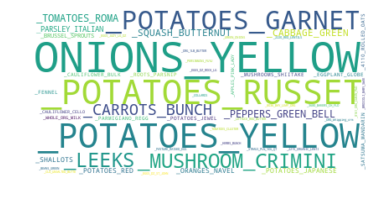

<img src="./img/2018/year.topic2.png">
Topic #3:
['GARLIC WHITE', 'GINGER', 'ONIONS RED', 'MUSHROOM CRIMINI', 'SHALLOTS', 'MUSHROOMS SHIITAKE', 'ROOT TURMERIC', 'ONIONS WHITE', 'PARMIGIANO REGG', '5290 WALNUTS', 'POTATOES GARNET', 'LEMONS MEYER', 'POTATOES JAPANESE', 'POTATOES YELLOW', 'LEEKS', 'SATSUMA MANDARIN', 'CAULIFLOWER BULK', 'BEANS GREEN', 'PARSLEY ITALIAN', '8571 TURM PWD ORG', 'BRUSSEL SPROUTS', '8161 ORG CUMIN PWD', '5120 ORG ALMONDS', 'BEETS RED LOOSE', 'ORANGES NAVEL', 'HERBS BUNCH', 'GREEN ONIONS', '3680 BAKERS CH FLO', 'COLLARDS', 'POTATOES JEWEL', 'BOK CHOY BABY', 'KALE GREEN', 'SPINACH LOOSE', '4110 ROLLED OATS', '6645 SUNFLWR SEEDS', 'KALE DINO', 'SHIITAKES BABY', 'STRAUS PLN YOG QT', 'SQUASH BUTTERNUT', 'BROCCOLI BABY SWEE', 'ASPARAGUS', 'EGGPLANT GLOBE', '8160 CUMIN SD ORG', 'MUSHROOM LS MAITAK', 'APPLES PINK LADY', 'KALE RED BOR', '5161 CASHEW PIECES', 'POTATOES RUSSET', '5250 ORG PECAN HA', 'LEMONGRASS']


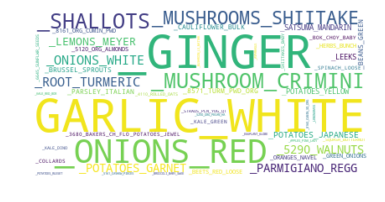

<img src="./img/2018/year.topic3.png">
Topic #4:
['LEMONS', 'LIMES', 'GINGER', 'PARSLEY ITALIAN', 'HERBS BUNCH', 'ORANGES VALENCIA', 'GRAPEFRUIT', 'SHALLOTS', 'CUCUMBERS', 'ORANGES NAVEL', 'BROCCOLI BABY SWEE', 'FENNEL', 'BLUEBERRY', 'PARMIGIANO REGG', 'ASPARAGUS', 'SATSUMA MANDARIN', 'KALE GREEN', 'KIWI LOOSE', 'ARUGULA LOOSE', 'APPLES PINK LADY', 'KALE DINO', 'ROOT TURMERIC', 'super greens', 'DILL', 'APPLES GALA', 'CALIFIA UNSWT', 'HERBS BASIL', 'CLO UNSALTED BUTTE', 'BABY ARUGULA CLAM', 'POTATOES GARNET', 'SUGAR PLUM CLAM', 'RADDICHIO', 'CUCUMBERS ENGLISH', 'CUKE MEDIT/PERSIAN', 'MANGO', 'RASPBERRY PACKAGE', '2448 CASTEL OLIVE', 'BRUSSEL SPROUTS', 'TOMATO', 'LIL GEM LETTUCE', 'TOMATO MIX HEIRLOO', 'HERBS SPEARMINT BU', 'BLACKBERRY PACK', 'LACROIX GRPFRT12pk', 'ORG Whipping crm', '5120 ORG ALMONDS', 'RADISHES RED/FRENC', 'PERSIMMONS FUYU', 'POTATOES RUSSET', 'POMEGRANATES']


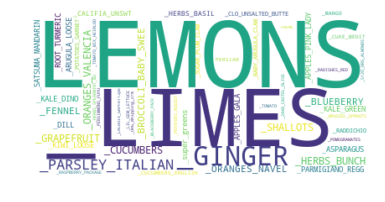

<img src="./img/2018/year.topic4.png">
Topic #5:
['CELERY', 'CUCUMBERS', 'PARSLEY ITALIAN', 'CARROTS BUNCH', 'LEEKS', 'GINGER', 'KALE DINO', 'BEETS RED LOOSE', 'FENNEL', 'ROOT TURMERIC', 'KALE GREEN', 'HERBS BUNCH', 'DANDELION', 'COLLARDS', 'LETTUCE ROMAINE', 'RADISHES RED/FRENC', 'SPINACH BUNCHED', 'PEPPERS GREEN BELL', 'CABBAGE RED', 'ONIONS GREEN', 'CABBAGE GREEN', 'PARSLEY CURLY', 'ORANGES NAVEL', 'BEETS RED BUNCHED', 'CHARD RAINBOW', 'ROOTS PARSNIP', 'CHARD RED', 'DILL', 'POTATOES RED', 'ASPARAGUS', 'CARROTS BABY', 'POTATOES RUSSET', 'GRAPEFRUIT', 'LETTUCE RED LEAF', 'LEMONS MEYER', 'POTATOES YELLOW', 'POTATOES JAPANESE', 'KALE RED BOR', 'CARROT RBO/PURPLE', 'BOK CHOY BABY', 'POTATOES GARNET', 'ARTICHOKES', 'SPINACH LOOSE', 'GREEN CHARD', 'SQUASH BUTTERNUT', 'BRUSSEL SPROUTS', 'LETTUCE GREEN LEAF', 'LEMON BAG', 'CAULIFLOWER BULK', '2215 ORGANIC LENTI']


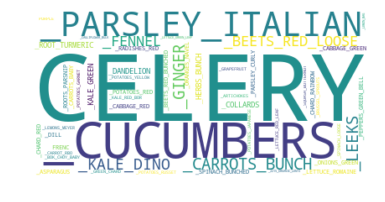

<img src="./img/2018/year.topic5.png">
Topic #6:
['CILANTRO', 'PEPPER CHILI', 'LIMES', 'ONIONS RED', 'ONIONS GREEN', 'PARSLEY ITALIAN', 'HERBS BUNCH', 'GINGER', 'TOMATOES ROMA', 'SHALLOTS', 'RADISHES RED/FRENC', 'CABBAGE RED', 'DILL', 'CUKE MEDIT/PERSIAN', 'ONIONS WHITE', 'CABBAGE GREEN', 'LEMONS MEYER', 'PEPPERS GREEN BELL', 'MUSHROOMS SHIITAKE', 'TOMATO MIX HEIRLOO', 'EGGPLANT GLOBE', 'FENNEL', 'LEEKS', 'LEMONGRASS', 'GREEN ONIONS', 'HERBS BASIL', 'ROOT TURMERIC', 'CAULIFLOWER BULK', 'CUCUMBERS ENGLISH', 'BROCCOLI BABY SWEE', 'DANDELION', 'LETTUCE ROMAINE', 'TOMATO', 'SUGAR PLUM CLAM', 'SPINACH BUNCHED', 'BOK CHOY BABY', 'MANGO', 'ARUGULA LOOSE', 'KALE GREEN', 'HERBS SPEARMINT BU', 'TOMATOES CLUSTER', '8161 ORG CUMIN PWD', 'ORG Y CORN TORT', 'CAULIFLOWER CELLO', 'TOMATILLOS', 'LIL GEM LETTUCE', '8160 CUMIN SD ORG', 'RADDICHIO', 'SQUASH BUTTERNUT', 'MUNG BEAN SPROUT']


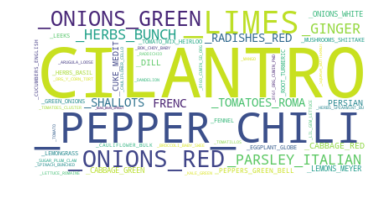

<img src="./img/2018/year.topic6.png">
Topic #7:
['PEPPERS RED BELL', 'CUCUMBERS', 'PEPPERS GREEN BELL', 'PEPPERS YELLOW BEL', 'PEPPERS ORANGE BEL', 'ONIONS RED', 'MUSHROOM CRIMINI', 'EGGPLANT GLOBE', 'TOMATOES ROMA', 'SUGAR PLUM CLAM', 'LETTUCE SALAD MIX', 'SPINACH LOOSE', 'BEANS GREEN', 'CUKE MEDIT/PERSIAN', 'LETTUCE RED LEAF', 'CARROTS BABY', 'PEPPER CHILI', 'TOMATO', 'LETTUCE ROMAINE', 'MIX CHERRY TOMATO', 'ORANGES NAVEL', 'PEAS SNAP', '2450 KALAMATA-PIT', 'POTATOES GARNET', 'CUCUMBERS ENGLISH', 'CABBAGE RED', 'APPLES PINK LADY', 'TOMATOES CLUSTER', 'POTATOES RUSSET', 'CHERRY TOMATO CLAM', '4110 ROLLED OATS', 'WILDWOOD 16oz TOFU', 'CAULIFLOWER BULK', 'LETTUCE GREEN LEAF', 'KALE GREEN', 'WILD 2 PACK', 'KIWI LOOSE', 'SPROUTED FIRM TOFU', 'APPLES GALA', 'LETTUCE RED BUTTER', 'ASPARAGUS', 'GREEN ONIONS', 'MUSHROOM PORTOBELL', 'ONIONS WHITE', 'CROOK/STRAIGHT NEC', 'BRUSSEL SPROUTS', 'MANGO', 'RADISHES RED/FRENC', 'POTATOES RED', 'PEAR BARTLETT']


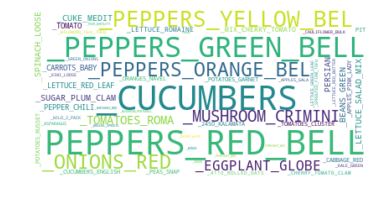

<img src="./img/2018/year.topic7.png">
Topic #8:
['SQUASH ZUCCHINI', 'BEANS GREEN', 'MUSHROOM CRIMINI', 'EGGPLANT GLOBE', 'BROCCOLI LOOSE', 'CROOK/STRAIGHT NEC', 'TOMATOES ROMA', 'GOLD BAR', 'CAULIFLOWER BULK', 'BOK CHOY BABY', 'ASPARAGUS', 'SQUASH SUNBURST', 'POTATOES YELLOW', 'PEPPERS GREEN BELL', 'LEEKS', 'POTATOES GARNET', 'CAULIFLOWER CELLO', 'MUSHROOMS SHIITAKE', 'POTATOES RED', 'KALE GREEN', 'BROCCOLI BABY SWEE', 'SPINACH LOOSE', 'CABBAGE GREEN', 'CHARD RAINBOW', 'PEPPERS ORANGE BEL', 'SQUASH BUTTERNUT', 'CHARD RED', 'POTATOES JAPANESE', 'ONIONS GREEN', 'CORN', 'PEPPERS YELLOW BEL', 'BRUSSEL SPROUTS', 'FENNEL', 'POTATOES JEWEL', 'SPINACH BUNCHED', 'TOMATO', 'MUSHROOM PORTOBELL', 'SUGAR PLUM CLAM', 'ROMANESQUE', 'GREEN CHARD', 'LETTUCE RED LEAF', 'BOK CHOY', 'COLLARDS', 'BEETS RED LOOSE', 'CABBAGE RED', 'CARROT RBO/PURPLE', 'KIWI LOOSE', 'ONIONS WHITE', 'PEAR BOSC', 'TOMATOES CLUSTER']


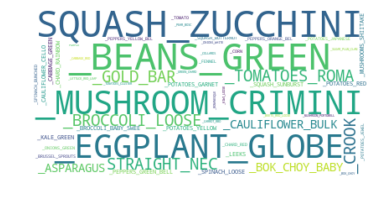

<img src="./img/2018/year.topic8.png">
Topic #9:
['CARROTS LOOSE', 'BROCCOLI LOOSE', 'LETTUCE SALAD MIX', 'BEETS RED LOOSE', 'POTATOES YELLOW', 'MUSHROOM CRIMINI', 'SPINACH LOOSE', 'TOMATOES ROMA', 'ORANGES NAVEL', 'POTATOES GARNET', 'BEANS GREEN', 'KALE DINO', 'CABBAGE RED', 'POTATOES RUSSET', 'APPLES GALA', 'CABBAGE GREEN', 'KALE GREEN', 'POTATOES RED', 'LEEKS', '5290 WALNUTS', 'CAULIFLOWER BULK', 'POTATOES JAPANESE', 'ORANGES VALENCIA', 'APPLES PINK LADY', 'ROOTS PARSNIP', 'PEAR BOSC', 'GINGER', 'COLLARDS', '4110 ROLLED OATS', '5120 ORG ALMONDS', 'LETTUCE RED LEAF', 'BRUSSEL SPROUTS', 'MUSHROOMS SHIITAKE', 'CHARD RED', 'SATSUMA MANDARIN', '6645 SUNFLWR SEEDS', 'ROOTS TURNIP LOOSE', 'ONIONS RED', 'POTATOES JEWEL', '4125 OG STL CUT OA', 'TOMATO', '4105 QUICK OATS', '4110org rolledOATS', 'SPROUTED FIRM TOFU', 'PEPPERS GREEN BELL', '2215 ORGANIC LENTI', 'ARUGULA LOOSE', 'KIWI LOOSE', 'PEAR BARTLETT', 'CHARD RAINBOW']


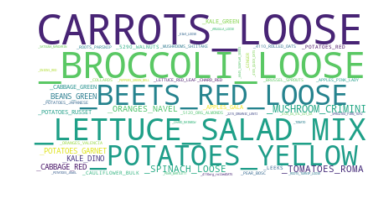

<img src="./img/2018/year.topic9.png">


In [116]:
def print_top_items(model, feature_names, n_top_words):
    topic_dict = defaultdict()
    topics =[]
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        #topic_string=(" ".join([feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]]))
        topic_string=[feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_dict[topic_idx]=topic_string
        topics.append(topic_string)
        print(topic_string)
        #print()
        wordcloud = WordCloud(max_font_size=500, max_words=1000, background_color="white").generate(str(topic_string).replace(" ", "_").replace("'",""))

        # Display the generated image:
        #plt.figure(1,figsize=(10,10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        #plt.savefig('topic%d.png'%topic_idx)
        #plt.close()
        wordcloud.to_file('./img/2018/year.topic%d.png'%topic_idx)
        print('<img src="./img/2018/year.topic%d.png">'%topic_idx)
    return topic_dict
topics = print_top_items(model,list(items_set),n_top_words)
#print("stopwords:",stopwords,"number of topics:",len(topics))

In [12]:
topics3=topics.copy()

In [13]:
topic_compare =np.zeros([len(topics),len(topics)])

for topic in topics:
    for item in topics[topic]:
        for topic2 in topics:
            #print (item)
            #print (type(topics[topic2]))
            if item in topics[topic2]:
                topic_compare[topic,topic2]+=1
            
print(topic_compare)


[[200. 103.  90.  72.  78.  76.  77.  88.  42.  79. 107.  78. 102.  95.
  107. 113.  81.  91.  67.  80.]
 [103. 200.  89.  80. 102.  81.  66. 100.  51.  77.  87.  87.  86. 104.
   98. 114. 102.  93.  94. 103.]
 [ 90.  89. 200. 134.  93.  87.  98.  82.  72.  94.  88.  86.  97. 101.
   74.  98.  92.  85. 100.  72.]
 [ 72.  80. 134. 200. 100.  80.  97.  75.  65.  71.  75.  76.  86.  95.
   61.  77.  83.  80.  98.  69.]
 [ 78. 102.  93. 100. 200.  95.  89.  99.  57.  62.  87.  93.  82.  93.
   95.  75.  77.  99.  85.  83.]
 [ 76.  81.  87.  80.  95. 200. 104.  85.  71.  65. 100. 113.  81.  79.
   91. 100.  47.  74.  72.  79.]
 [ 77.  66.  98.  97.  89. 104. 200.  77.  87.  68.  99.  96. 102.  81.
   85.  84.  43.  92.  69.  70.]
 [ 88. 100.  82.  75.  99.  85.  77. 200.  33.  54.  95.  76.  82.  84.
   96.  96.  79.  82.  64.  85.]
 [ 42.  51.  72.  65.  57.  71.  87.  33. 200.  80.  65.  87.  62.  69.
   55.  63.  38.  58. 103.  56.]
 [ 79.  77.  94.  71.  62.  65.  68.  54.  80. 200.  75

In [39]:
list_of_topics=[]
for topic in topics:
     list_of_topics.append(topics[topic])

In [40]:
len(topics[0])

25

In [11]:
ingredients =np.array((len(topics),len(topics[0])))
for row in topics:
    print('row',row)
    for i,item in enumerate(topics[row]):
        if item not in topics[row]:
            print ('i',i,item)
            
        if item not in topics[0]:
            print ('iI',i,item)
        #ingredients[row:i]=item
ingredients

row 0
row 1
iI 0 Zuzu Eye Palette
iI 1 MUIR-DICED TOMATO
iI 2 BAMBU TONGS
iI 3 VERMONT QUARK
iI 4 HICKORY PRIMAL STR
iI 5 HY Headache 100t
iI 6 BIG D IVORY TAPER
iI 7 BLK MISSION FIG
iI 8 8360 BLK MACA ORG
iI 9 FRANTOIA EXTRA
iI 10 GD SPR HEMPS BURGR
iI 11 Epsom Salts Bulk
iI 13 ADHESIVE HOOKS
iI 14 CHARD KNOCK LIFE
iI 15 Avocado Shampoo
iI 17 OXO NYLON TURNER
iI 18 SR Amla 60vegcap
iI 19 NAGO GARLIC ONION
row 2
iI 0 RAW CREAM
iI 2 CITRUS TARTLETS
iI 5 TURN OFF PHONE
iI 6 Almond Facial Loti
iI 9 EC Milk Thistle 1o
iI 10 FB HairSkin Nail 1
iI 11 2405 KOSHER SALT
iI 13 MUIR-DICED TOMATO
iI 15 AIRSCENSE LAVENDER
iI 16 AL NOYA Curios WHT
iI 17 8067 BREATHE WELL
iI 19 SG Potassium 100ta
row 3
iI 0 UHarrys Hair Elixi
iI 1 EC Meno Spt 1oz
iI 2 AIRSCENSE LAVENDER
iI 4 8067 BREATHE WELL
iI 5 Gauze Pads 25ct
iI 7 SG Potassium 100ta
iI 8 Now Peppermint 16o
iI 9 8479 RED CLOVER WH
iI 11 2405 KOSHER SALT
iI 13 Almond Facial Loti
iI 14 BAMBU TONGS
iI 16 IH SPRTD PUMPKIN
iI 17 TBE GRANOLA 1LB
iI 19 G

array([10, 20])

In [42]:
len(ing_set)

NameError: name 'ing_set' is not defined

In [225]:
ing_index_dict = dict(zip(ing_set, range(len(ing_set))))

In [231]:
ingredients=np.array(ingredients)
ingredients=ingredients.reshape(5,55)

In [233]:
ingredients.shape

(5, 55)

In [234]:
ing_matrix=np.zeros(ingredients.shape)

In [244]:
for row,col in enumerate(ingredients):
    for i,c in enumerate(col):
        #print(row,i,c)
        ing_matrix[row,i]=ing_index_dict[c]
ing_matrix

array([[ 63.,  99.,  42.,  64., 112.,  14.,  21., 124.,  32.,  35.,  88.,
         68., 121., 130., 113., 120.,  38.,  95., 134.,  10.,  23.,  16.,
         27.,  41.,  96., 118.,  58., 101., 105.,  85.,  97.,  47.,  86.,
         29.,  20.,  91.,  15.,  55., 102.,  28.,  98.,   1., 119., 122.,
        132.,  11., 128.,  65.,  17.,  72.,  54.,   0.,  81., 125.,  25.],
       [100.,  32.,  64.,  19.,  88.,   1., 120.,  86.,   3.,   9.,  39.,
        105., 134.,  41.,  78.,  69.,  93., 131., 124.,  48.,  34.,  97.,
         67.,  57., 112.,  62.,  74.,   7.,  16.,  44., 115.,  91.,  65.,
         11., 123.,  14.,  68.,  53., 107.,  51.,  31.,   6.,  98., 102.,
         24., 121.,  61.,  49.,  55.,  12.,  82., 101., 133.,  60.,  75.],
       [ 37., 115.,  96.,  97.,  21.,   1.,  58.,  77.,  35.,   3., 105.,
        118.,  71., 130.,  85., 131., 104.,  87.,  19.,  15.,  43.,  38.,
        101.,   0.,  41.,   2.,  13., 127.,  62., 121.,  18.,  89.,  32.,
        102.,  50., 126.,  65.,  30.

In [255]:
ing_array=ing_index_dict.values()

ing_array

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134])

In [259]:
for i in ing_matrix:
    print(ing_array==i)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False

In [226]:
for ing_index_dict

{'SPINACH BUNCHED': 0,
 'POTATOES YELLOW': 1,
 'ROOTS TURNIP LOOSE': 2,
 'POTATOES RUSSET': 3,
 'SATSUMA MANDARIN': 4,
 'ORGANIC 2% MILK': 5,
 'PARMIGIANO REGGIAN': 6,
 'ORG 1LB BUTTER': 7,
 'BAG PINK LADY APPL': 8,
 '4110 ORG RLD OATS': 9,
 'TOMATO MIX HEIRLOO': 10,
 'GREEN ONIONS': 11,
 'BRUSSEL SPROUTS': 12,
 'PEAR BOSC': 13,
 'ONIONS GREEN': 14,
 'KALE GREEN': 15,
 'ORANGES BLOOD': 16,
 'CHARD RAINBOW': 17,
 'POTATOES RED': 18,
 'MUSHROOM CRIMINI': 19,
 'CUCUMBERS ENGLISH': 20,
 'PARSLEY ITALIAN': 21,
 'BLUEBERRIES': 22,
 'BROCCOLI BABY SWEE': 23,
 'CLO UNSALTED BUTTE': 24,
 'DAIKON WATERMELON': 25,
 '2215 ORGANIC LENTI': 26,
 'GRAPEFRUIT': 27,
 'RADDICHIO': 28,
 'BOK CHOY BABY': 29,
 'PEPPERS GREEN BELL': 30,
 'ORG WM QT CLOVER': 31,
 'ONIONS RED': 32,
 'STRAUS PLN YOG QT': 33,
 'EGGS DZ ST JOHN': 34,
 'KALE DINO': 35,
 '3080 MEDJOOL DATES': 36,
 'CELERY': 37,
 'CAULIFLOWER CELLO': 38,
 'EGGPLANT GLOBE': 39,
 'DAIKON': 40,
 'TOMATOES ROMA': 41,
 'LIMES': 42,
 'CHARD RED': 43,
 'BA

In [53]:
def print_basket_contents(basket_id):
    basket=[]
    #print('+++++++++++++++++++++++next basket+++++++++++++++++')
    for items in df['items'][basket_id]:
        #for item in items:
        print("item:",items)
    #return basket
#print_basket_contents(1116)

In [54]:
def print_top_baskets(model, W, n_top_words):
    baskets = []
    for topic_idx, w in enumerate(W.T):
        basket_string=str([df['items'][i] for i in w.argsort()[:-n_top_words - 1:-1]])
        count = 0
        for i in w.argsort()[:-n_top_words - 1:-1]:
            count+=1
            print("++++++++++++++++++Topic #%d, basket #%d+++++++++++++++++++"%(topic_idx,count))
            print_basket_contents(i)
        #print_basket_contents([i for i in w.argsort()[:-n_top_words - 1:-1]])
        baskets.append(basket_string)
        #print(basket_string)
        #print()
        '''wordcloud = WordCloud(max_font_size=500, max_words=1000, background_color="white").generate(basket_string.replace(" ", "_").replace("'",""))

        # Display the generated image:
        #plt.figure(1,figsize=(10,10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        #plt.savefig('topic%d.png'%topic_idx)
        #plt.close()
        wordcloud.to_file('topic%d.png'%topic_idx)'''
print_top_baskets(model,W,10)

++++++++++++++++++Topic #0, basket #1+++++++++++++++++++
item: ['', 'SPINACH LOOSE', 3.08, 12]
item: ['', 'NECTARINE', 17.61, 12]
item: ['', 'KALE DINO', 2.49, 12]
item: ['', 'SPRT CORN TORTILLA', 3.29, 17]
item: ['', 'PLUOT/PLUM RED', 6.44, 12]
item: ['', '3675 OAT FLOUR', 1.7000000000000002, 16]
item: ['', 'BEANS GREEN', 1.53, 12]
item: ['', '2124OG YEL CHANA D', 3.5, 16]
item: ['', 'BEETS RED LOOSE', 1.07, 12]
item: ['', 'BROCCOLI LOOSE', 1.3900000000000001, 12]
item: ['', 'CLARAVALE COW MILK', 34.14, 13]
item: ['DP', 'BOTTLE DEPOSIT', 12.0, 21]
item: ['', 'CLARA RAW GOAT QT', 45.45, 13]
item: ['DP', 'BOTTLE DEPOSIT', 10.0, 21]
item: ['', 'CILANTRO', 1.5899999999999999, 12]
item: ['', 'MUSHROOM CRIMINI', 0.74, 12]
item: ['', 'CUCUMBERS', 4.16, 12]
item: ['', 'POTATOES GARNET', 2.18, 12]
item: ['', 'TOMATO DRY FARM', 7.1, 12]
item: ['', 'LETTUCE SALAD MIX', 1.75, 12]
item: ['', '5833 RICE PENNE', 4.41, 16]
item: ['', 'SQUASH ZUCCHINI', 3.44, 12]
item: ['', 'LEMONS', 7.88, 12]
item: [

++++++++++++++++++Topic #1, basket #1+++++++++++++++++++
item: ['', 'STRAUS MILK GALLON', 8.49, 13]
item: ['', 'STRAU GREEK YOGURT', 7.49, 13]
item: ['', 'STRAUS PLN YOG QT', 5.29, 13]
item: ['', 'CASATICA', 7.47, 14]
item: ['', 'PARMIGIANO REGGIAN', 8.96, 14]
item: ['', 'PAPILLON PERAIL', 6.99, 14]
item: ['', 'MILD CHEDDAR CHEES', 3.02, 14]
item: ['', 'CHILE VERDE BKFST', 5.09, 13]
item: ['', 'YOUSEFS 8oz HUMMUS', 3.55, 13]
item: ['', 'WOOD PETITE PEAS', 2.39, 19]
item: ['', 'WOOD PETITE PEAS', 2.39, 19]
item: ['', 'SEAS SHELLED EDAMA', 3.39, 19]
item: ['', 'KLARE MELK', 7.22, 14]
item: ['', 'ORANGES VALENCIA', 4.92, 12]
item: ['', 'ORANGES NAVEL', 10.07, 12]
item: ['', 'APPLES FUJI', 15.88, 12]
item: ['', 'PEAR BARTLETT', 6.49, 12]
item: ['', 'GRAPEFRUIT', 1.37, 12]
item: ['', 'BANANAS', 3.24, 12]
item: ['', 'POTATOES RUSSET', 20.53, 12]
item: ['MP', 'BAG CREDIT', -0.05, 23]
item: ['', 'SC APRCT APPLE SAU', 4.59, 15]
item: ['', 'KIWI LOOSE', 6.8100000000000005, 12]
item: ['MP', 'BAG 

++++++++++++++++++Topic #2, basket #1+++++++++++++++++++
item: ['', 'EEBOO LUNCH BAG', 29.99, 8]
item: ['', 'Bib/Drool Cl Set', 14.95, 4]
item: ['', 'CANDY CANES', 3.99, 15]
item: ['', 'RUSTIC FLATBREAD', 5.99, 14]
item: ['', 'CHAMOMILE TEA', 3.19, 15]
item: ['', 'SUNWINK TONIC', 4.99, 13]
item: ['', 'SMALL COOLER CRV', 0.05, 13]
item: ['', 'PPMNT BLISTER PACK', 1.49, 15]
item: ['', 'PPMNT BLISTER PACK', 1.49, 15]
item: ['', 'CINNAMON BLISTER', 1.49, 15]
item: ['', 'LATE JULY-SALTINES', 2.99, 15]
item: ['', 'ORIGINAL', 1.3900000000000001, 15]
item: ['', 'Sabor Orig', 5.19, 15]
item: ['', 'LUND SEAWD RCE CHP', 2.89, 15]
item: ['', 'TALENTI RASP SORBT', 6.09, 19]
item: ['', 'HEALTH ADE BOCG', 3.79, 13]
item: ['', 'SMALL COOLER CRV', 0.05, 13]
item: ['', 'HEALTH ADE BOCG', 3.79, 13]
item: ['', 'SMALL COOLER CRV', 0.05, 13]
item: ['', 'DELISH FISH', 3.29, 15]
item: ['', 'CARAMELS GINGERBRE', 5.99, 15]
item: ['', 'CARAMEL BITES CINN', 5.99, 15]
item: ['', 'JILZ GF TUSCAN', 6.29, 15]
item: [

++++++++++++++++++Topic #3, basket #1+++++++++++++++++++
item: ['', 'CAL OLIVE OIL 25oz', 12.99, 15]
item: ['', 'NC ORG APPLE SAUCE', 3.59, 15]
item: ['', 'Clover ORG cottchs', 4.59, 13]
item: ['', 'BTTRMLK QT CLOVER', 2.29, 13]
item: ['', 'NC ORG APPLE SAUCE', 3.59, 15]
item: ['', 'Wallaby 32oz greek', 8.19, 13]
item: ['', 'ORG GAL CLOVER', 6.99, 13]
item: ['', 'Wallaby 32oz greek', 8.19, 13]
item: ['', 'Clover ORG cottchs', 4.59, 13]
item: ['', 'BTN-CRSPY WHT CRKR', 2.99, 15]
item: ['', 'BTN-CRSPY WHT CRKR', 2.99, 15]
item: ['', 'ORG GAL CLOVER', 6.99, 13]
item: ['', 'BTN-HRVST WHT CRKR', 2.99, 15]
item: ['', 'STRINGLES 6-PACK', 5.69, 14]
item: ['', 'CLOVER YOGURT 32OZ', 4.49, 13]
item: ['', 'NUMI RUBY CHAI', 6.19, 15]
item: ['', 'STAHL BLACKBERRIES', 3.99, 19]
item: ['', 'STAHL BLUEBERRIES', 3.99, 19]
item: ['', 'Clover ORG cottchs', 4.59, 13]
item: ['', 'STAHL BLACKBERRIES', 3.99, 19]
item: ['', 'BANANAS', 2.02, 12]
item: ['', 'NCorg ap JUICE', 3.99, 15]
item: ['', 'CRV SMALL NO TA

++++++++++++++++++Topic #4, basket #1+++++++++++++++++++
item: ['', 'EGGS DZ ROCK LG', 3.49, 13]
item: ['', 'BELFIORE BURRATA', 5.99, 14]
item: ['', 'EGGOLOGY EGG WHITE', 3.59, 13]
item: ['', 'EGGOLOGY EGG WHITE', 3.59, 13]
item: ['', 'STRAUS YOGURT QT', 4.69, 13]
item: ['', 'STRAUS YOGURT QT', 4.69, 13]
item: ['', 'ORG DANISH RYE', 6.99, 17]
item: ['', 'POMEGRANATE', 3.79, 13]
item: ['', 'SMALL COOLER CRV', 0.05, 13]
item: ['', 'POMEGRANATE', 3.79, 13]
item: ['', 'SMALL COOLER CRV', 0.05, 13]
item: ['', 'HERBS BUNCH', 1.69, 12]
item: ['', 'TOMATO MIX HEIRLOO', 4.54, 12]
item: ['', 'HI-BALL GRAPEFRUIT', 2.79, 15]
item: ['', 'CRV SMALL SING T', 0.05, 15]
item: ['', 'HI-BALL WILD BERRY', 2.79, 15]
item: ['', 'CRV SMALL SING T', 0.05, 15]
item: ['', 'HEALTH ADE BEET', 3.79, 13]
item: ['', 'SMALL COOLER CRV', 0.05, 13]
item: ['', 'HI-BALL WILD BERRY', 2.79, 15]
item: ['', 'CRV SMALL SING T', 0.05, 15]
item: ['', 'HEALTH ADE PINK LA', 3.79, 13]
item: ['', 'SMALL COOLER CRV', 0.05, 13]
item:

++++++++++++++++++Topic #5, basket #1+++++++++++++++++++
item: ['', 'CARROTS LOOSE', 3.64, 12]
item: ['', 'CELERY', 2.81, 12]
item: ['', 'CUCUMBERS', 4.1, 12]
item: ['', 'CELERY', 5.26, 12]
item: ['', 'APPLES FUJI', 5.8, 12]
item: ['', 'COLLARDS', 1.79, 12]
item: ['', 'BOK CHOY', 4.08, 12]
item: ['', 'CABBAGE RED', 2.24, 12]
item: ['MP', 'BAG CREDIT', -0.1, 23]
item: ['', 'KALE DINO', 1.99, 12]
item: ['', 'BEANS GREEN', 2.87, 12]
item: ['', 'KALE GREEN', 1.79, 12]
item: ['', 'CABBAGE GREEN', 2.19, 12]
item: ['', 'KALE DINO', 1.99, 12]
item: ['', 'KALE DINO', 1.99, 12]
item: ['', 'KALE DINO', 1.99, 12]
item: ['', 'PARSLEY ITALIAN', 1.5899999999999999, 12]
item: ['', 'TOMATOES ROMA', 3.26, 12]
item: ['', 'BEETS RED LOOSE', 1.27, 12]
item: ['', 'POTATOES GARNET', 3.8, 12]
item: ['', 'ONIONS RED', 1.0, 12]
item: ['', 'MALK UNSWT CASHEW', 7.59, 13]
item: ['', 'SMALL COOLER CRV', 0.05, 13]
item: ['', 'MANGO', 2.66, 12]
item: ['', 'HOUSE JASMINE', 3.99, 13]
item: ['', 'SMALL COOLER CRV', 0.05

++++++++++++++++++Topic #6, basket #1+++++++++++++++++++
item: ['', 'BROWN RICE WRAP', 3.69, 15]
item: ['', 'COCONUT WRAPS', 9.99, 15]
item: ['', 'ALMOND TORTILLA', 8.99, 17]
item: ['', 'BANANAS', 1.27, 12]
item: ['', 'PAC-VEG BROTH 32oz', 2.99, 15]
item: ['', 'IMAG NO-CHKN BROTH', 2.5, 15]
item: ['', 'SQUASH ZUCCHINI', 3.5700000000000003, 12]
item: ['RF', 'SQUASH ZUCCHINI', -0.5700000000000001, 12]
item: ['', 'CUKE MEDIT/PERSIAN', 1.04, 12]
item: ['', 'GINGER', 1.3, 12]
item: ['', 'AVOCADOS HASS', 3.29, 12]
item: ['', 'ONIONS YELLOW', 0.58, 12]
item: ['', 'ONIONS WHITE', 0.61, 12]
item: ['', 'ONIONS RED', 0.89, 12]
item: ['', 'SHALLOTS', 0.65, 12]
item: ['', 'APPLES PINK LADY', 3.89, 12]
item: ['MP', 'BAG CREDIT', -0.05, 23]
item: ['', 'COYO ORIGINAL', 4.99, 13]
item: ['', 'PEPPER CHILI', 0.48, 12]
item: ['', 'RADISHES RED/FRENC', 1.99, 12]
item: ['', 'CARROTS BUNCH', 2.99, 12]
item: ['', 'KALE GREEN', 1.79, 12]
item: ['', 'LEMONGRASS', 0.55, 12]
item: ['', 'LIMES', 3.86, 12]
item: ['

In [427]:
df['item_count'].max()

2

In [ ]:
W[:,1]

In [ ]:
n_top_words=10
for i,w in enumerate(W.T):
    print(i,w.argsort()[:-n_top_words - 1:-1])

In [76]:
len(list(items_set))

6576

In [75]:
for topic in H:
    print (topic.argsort()[:-10-1:-1])

[1752 6585 2198 2188 2189 2190 2191 2192 2193 2194]
[1271 6539 4820   80 4966 1929 2604 6546 2660 4806]
[6114 3455  640 2958  537   84 2189 4025 1017 4051]
[3058 2646 2476 5751 5768 6309 4302 4243 3450 6388]
[1484 4994 5017  125 4381  102 1207  435 1811 4079]


In [ ]:
feat
str([feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]])

In [72]:
df.shape[0]
for i in range(10,11):
    row = df['items'][i:i+1]
    for item in row:
        for it in item:
            print (it[1],it[2])

4112 SINTO KIMCHI 13.54
PEPPERS RED BELL 2.75
CUCUMBERS 12.73
ORGANIC 2LB TOFU 20.95
5540 TAHINI 12.17
GINGER 4.79
GARLIC WHITE 3.01
PRODUCE SCALE 1.79
LIMES 2.0
CILANTRO 1.99
CILANTRO 1.99
BROCCOLI LOOSE 6.24
CELLO CAULIFLOWER 11.96
LEEKS 9.12
SUGAR PLUM CLAM 5.97
BEETS RED LOOSE 6.01
store 100% Bulks -34.5
store 100% Produce -70.35
store 100% Refrig -20.95


In [12]:
df.shape[0]
for i in range(10,11):
    row = df['items'][i:i+1]
    for item in row:
        for it in item:
            df[it[1]][i:i+1]=df[it[1]][i:i+1]+it[2]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
df['CILANTRO'][10:11]

10    3.98
Name: CILANTRO, dtype: float64

In [19]:
df.shape[0]
for i in range(1,df.shape[0]):
    row = df['items'][i:i+1]
    for item in row:
        for it in item:
            df[it[1]][i:i+1]=df[it[1]][i:i+1]+it[2]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
df.shape

(2535, 6586)

In [22]:
df.to_pickle('02012019.pkl')

In [213]:
len(items_set)

6576

In [114]:
trans = []
for a in df[1:2]['items']:
    #trans.append([r for v in a for r in v])
    trans.append(a)
print(a)

[['', 'BLUEBERRIES', 5.99, 12], ['', 'ALXNDRE YOGURT', 4.99, 13], ['MP', 'Worker 20% Produce', -1.2, 12], ['MP', 'Worker 20% Refrig', -1.0, 13]]


In [96]:
trans =[]
for l in [i for i in df[1:2]['items']]:
    print (l)
    trans.append(l)
    print (trans)

[['', 'BLUEBERRIES', 5.99, 12], ['', 'ALXNDRE YOGURT', 4.99, 13], ['MP', 'Worker 20% Produce', -1.2, 12], ['MP', 'Worker 20% Refrig', -1.0, 13]]
[[['', 'BLUEBERRIES', 5.99, 12], ['', 'ALXNDRE YOGURT', 4.99, 13], ['MP', 'Worker 20% Produce', -1.2, 12], ['MP', 'Worker 20% Refrig', -1.0, 13]]]


In [4]:
#pd.get_dummies([i for i in df[1:2]['items']]).values()

In [80]:

type(df['items'].values)
count=0
for document in df['items'][1]:
    print (document)
    
    for word in(document):
        count+=1
        print (count,word)
        '''for letter in str(word):
            print (letter)'''

['', 'BLUEBERRIES', 5.99, 12]
1 
2 BLUEBERRIES
3 5.99
4 12
['', 'ALXNDRE YOGURT', 4.99, 13]
5 
6 ALXNDRE YOGURT
7 4.99
8 13
['MP', 'Worker 20% Produce', -1.2, 12]
9 MP
10 Worker 20% Produce
11 -1.2
12 12
['MP', 'Worker 20% Refrig', -1.0, 13]
13 MP
14 Worker 20% Refrig
15 -1.0
16 13


NameError: name 'plt' is not defined

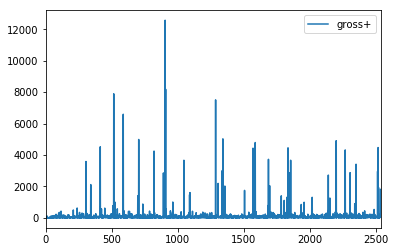

In [51]:
df[['gross+','time']].plot()
plt.show()

In [33]:
ff= './tlogs/201902'
if ff.startswith("./tlogs"):
    print ("yep")

yep


In [18]:
for f in os.walk('./tlogs'): print ("f:",f,"sub:",sub)


f: ('./tlogs', ['201902'], ['.DS_Store']) sub: []
f: ('./tlogs/201902', ['20190202', '20190203', '20190204', '20190205', '20190206', '20190207', '20190208', '20190209', '20190210', '20190211', '20190212', '20190213', '20190214', '20190215', '20190216', '20190217', '20190218', '20190219', '20190220', '20190221', '20190222', '20190223', '20190224', '20190225', '20190226', '20190227', '20190228', '20190301'], ['.DS_Store']) sub: []
f: ('./tlogs/201902/20190202', [], ['checklisting.txt', 'department.txt', 'Department01Discounts.txt', 'Department04Discounts.txt', 'Department06Discounts.txt', 'Department07Discounts.txt', 'Department08Discounts.txt', 'Department09Discounts.txt', 'Department10Discounts.txt', 'Department11Discounts.txt', 'Department12Discounts.txt', 'Department13Discounts.txt', 'Department14Discounts.txt', 'Department15Discounts.txt', 'Department16Discounts.txt', 'Department17Discounts.txt', 'Department19Discounts.txt', 'Department26Discounts.txt', 'dept.txt', 'discountitems.tx

In [ ]:
import os

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        #print os.path.join(subdir, file)
        filepath = subdir + os.sep + file

        if filepath.endswith(".asm"):
            print (filepath)

In [8]:
df=pd.read_pickle('02012019.pkl')

In [10]:
df[df['BANANAS']!=0]

,date,gross+,gross-,items,net,oper,term,time,trans,type,...,PRO BAR MINT CHOC,8213 FENNEL POWDER,OR Cooked Beets,JR Melatonin SR 12,NUT WALNUT,QT Elderbry Loz 36,SW WB Vanilla 12pk,6556 DUTCH COCOA,lvngClyBntonte 8oz,CARDAMOM BITTERS
36,2001-02-19,37.65,0.00,"[[, PASCHA UNSWT CCHIP, 4.99, 15], [, PRIMAVER...",37.65,104,5,09:16,8,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,2001-02-19,108.17,0.00,"[[, FORGER PL CSH YOG, 5.59, 13], [, SO DEL UN...",108.17,42,6,09:20,12,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65,2001-02-19,20.72,0.00,"[[, APPLES FUJI, 2.42, 12], [, 8308KEEMUN BLAC...",20.72,11,1,09:27,7,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73,2001-02-19,144.42,0.00,"[[, WOODSTK BLUEBERRIE, 6.29, 19], [, EVOLUTIO...",144.42,42,6,09:30,17,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74,2001-02-19,17.69,0.00,"[[, COELA ZIPPER TOTE, 9.99, 6], [, BANANAS, 2...",17.69,42,6,09:31,18,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,2001-02-19,224.03,0.00,"[[, APPLE JUICE, 11.39, 15], [, ORG GAL CLOVER...",224.03,104,5,09:32,21,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89,2001-02-19,80.01,0.00,"[[, MAC HAWAI SEA SALT, 7.99, 15], [, UMLAUT C...",80.01,42,6,09:35,21,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,2001-02-19,86.51,0.00,"[[, FLAVORG VANILLA4oz, 15.49, 15], [, SUGAR P...",86.51,34,8,09:39,12,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,2001-02-19,285.53,0.00,"[[, VH Kids Vibe Choc, 34.4, 1], [, EZ Ultimat...",285.53,11,1,09:40,18,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101,2001-02-19,55.73,0.00,"[[, QRT CAN JAR t101, 1.79, 6], [, QRT CAN JAR...",55.73,42,6,09:41,25,Checkout,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [200]:
df.columns

Index(['date', 'gross+', 'gross-', 'items', 'net', 'oper', 'term', 'time',
       'trans', 'type'],
      dtype='object')

In [ ]:
plt.scatter(x=df['time'],y=df['gross+'])

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [54]:
df.type='Va'

In [ ]:
def get_dataframe(filepath):

    all_files = glob.glob(os.path.join(filepath, "*.json"))
    df = pd.concat((pd.read_json(f,keep_default_dates=False,lines=True) for f in all_files)) 
    df=df[df['term']<10]
    df['date']=pd.to_datetime(df['date'],yearfirst=True)
    df['day_of_week']=df['date'].dt.day_name()
    df['month']=df['date'].dt.month
    return df

In [1]:
path = '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/'
df = get_dataframe(path)

NameError: name 'get_dataframe' is not defined

In [11]:
all_files =[]
for f in range(0,366):
    all_files.append(path+"%d.json"%f)
print (all_files)

['/Users/Sarah/galvanize/dsi-capstone/jsons/201802/0.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/1.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/2.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/3.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/4.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/5.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/6.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/7.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/8.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/9.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/10.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/11.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/12.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/13.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/14.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/15.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802

In [10]:
import pandas as pd 
df = pd.concat((pd.read_json(f,keep_default_dates=False,lines=True) for f in all_files)) 

ValueError: Expected object or value